#1) Importando e preparando os dados




##1.1 Contextualização


Para essa atividade adotamos o conjunto de dados de predição da produtivdade de cana 'fa084_tch_mult.csv', da atividade 8 da disciplina FA084/AP522 do 1º semestre de 2020.

##1.2 Bibliotecas básicas

In [ ]:
#importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor # Xtreme Gradient Boosting

##1.3 Carregando o arquivo 

In [ ]:
#importar o arquivo e criar o df
df = pd.read_csv('fa084_tch_mult.csv')
# Excluir 'espac'
df.drop('espac',axis=1,inplace=True)
# Excluir os registros com estágio de corte 7
df = df[df.estagio!=7]
# Considerar somente as três variedades mais frequentes e excluir as demais
variedade_freq=df.variedade.value_counts().head(3)
df = df.loc[df.variedade.isin(variedade_freq.index)]
#encode atributos categoricos
df = pd.get_dummies(df)
# Separar atributos preditores(X) do atributo meta (y)
y = df.tch
X = df.drop('tch', axis=1)
# Criar X_train, X_test, y_train, y_test com as proporções 70/30 e random_state = 2020
X_train , X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 2020)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5995, 16) (2570, 16) (5995,) (2570,)


#2) Modelo

##2.1 Justificativa para escolha do modelo

Foi selecionado somente o modelo que apresentou o melhor desempenho na atividade (XGB). Para ganhar tempo os hiperparametros otimizados por busca randomica foram informados.

##2.2 Ajuste do modelo

In [ ]:
#X-treme Gradient Boosting
#Best parameters: {'max_depth': 13, 'n_estimators': 4701}
%%time

XGB = XGBRegressor(objective='reg:squarederror', random_state=2020, n_estimators=4701, max_depth=13).fit(X_train, y_train)

CPU times: user 30.6 s, sys: 98.3 ms, total: 30.7 s
Wall time: 30.7 s


#3) ML Interpretability methods

##3.1 Built-in

In [ ]:
#XGB.feature_importances_

df_xgb_fi = pd.DataFrame({'Feature importance': XGB.feature_importances_},
                         index = X_train.columns)
df_xgb_fi.sort_values('Feature importance', ascending=False)

,Feature importance
variedade_RB855453,0.723723
estagio,0.129379
variedade_RB867515,0.022510
ppt_i,0.020098
ppt_ii,0.019772
ppt_iii,0.018702
solo_R,0.014097
solo_O,0.010673
lstn_i,0.008990
lstn_ii,0.006875


##3.2 Permutation Importance

In [ ]:
#instalando bibliotecas
!pip install eli5

#importando as bibliotecas
import eli5
from eli5.sklearn import PermutationImportance

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
#Feature importance calculation
perm = PermutationImportance(XGB, random_state=2020).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.4726 ± 0.0241,estagio
0.2485 ± 0.0135,ppt_ii
0.2206 ± 0.0230,ppt_i
0.1839 ± 0.0149,variedade_RB855453
0.1538 ± 0.0065,ppt_iii
0.1271 ± 0.0156,lstd_iii
0.1261 ± 0.0095,lstn_ii
0.1171 ± 0.0067,lstn_iii
0.1158 ± 0.0100,lstd_ii
0.1106 ± 0.0021,lstn_i


##3.3 Partial Dependence Plot (PDP)

In [ ]:
#instalando bibliotecas
!pip install pdpbox

#importando as bibliotecas
from pdpbox import pdp, get_dataset, info_plots

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


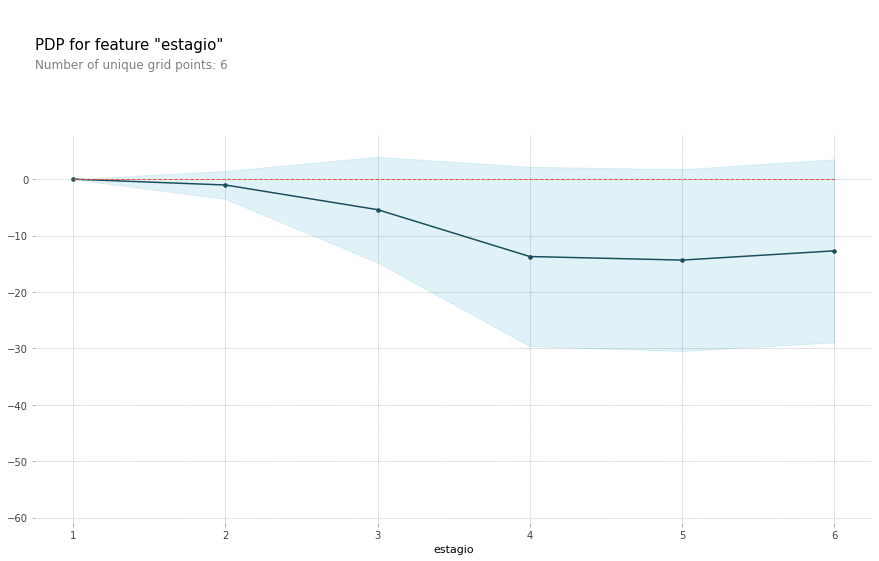

In [ ]:
# Create the data that we will plot
pdp_estagio = pdp.pdp_isolate(model=XGB, dataset=X_test, model_features=X_test.columns, feature='estagio')

# plot it
pdp.pdp_plot(pdp_estagio, 'estagio')
plt.show()

##3.4 Individual Conditional Expectation (ICE)

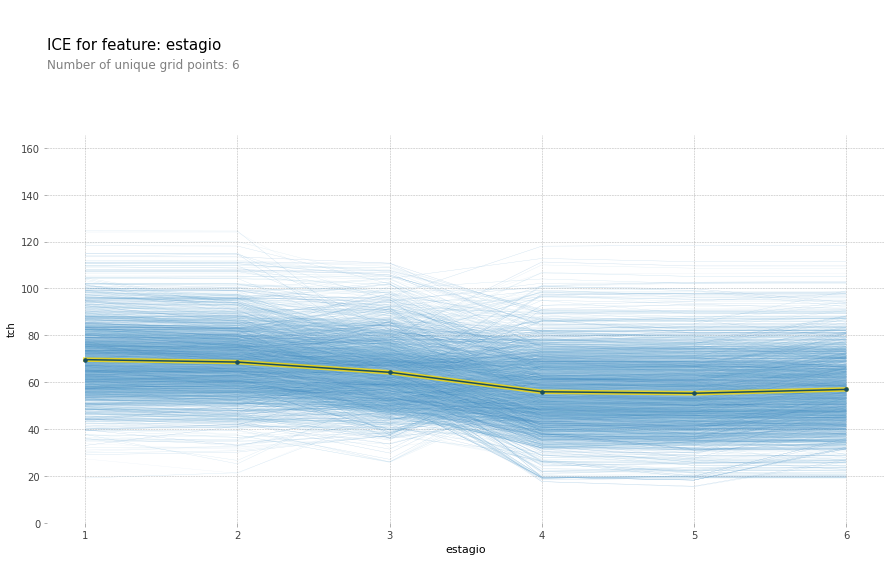

In [ ]:
# plot ICE
fig, ax = pdp.pdp_plot(pdp_estagio, 'estagio', plot_lines=True, center=False,
                       plot_params= {  
            # plot title and subtitle  
            'title': 'ICE for feature: estagio',    
            'title_fontsize': 15,  
            'font_family': 'Arial',
        })
plt.ylabel('tch');

##3.5 2D PDP

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


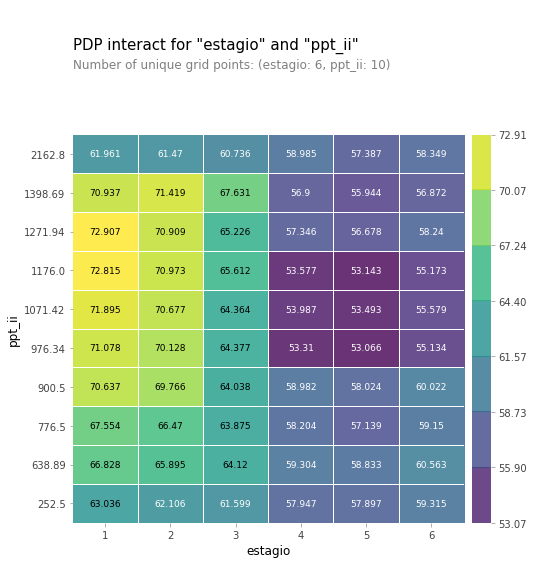

In [ ]:
features_to_plot = ['estagio', 'ppt_ii']
inter1  =  pdp.pdp_interact(model=XGB, dataset=X_test, model_features=X_test.columns, features=features_to_plot)

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='grid')
plt.show()

##3.6 Global Surrogate

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

#XGB predictions
y_pred = XGB.predict(X_test)

In [ ]:
#Global surrogate model
tree_model = DecisionTreeRegressor(random_state=2020, max_depth=5, min_samples_split=5).fit(X_test, y_pred)

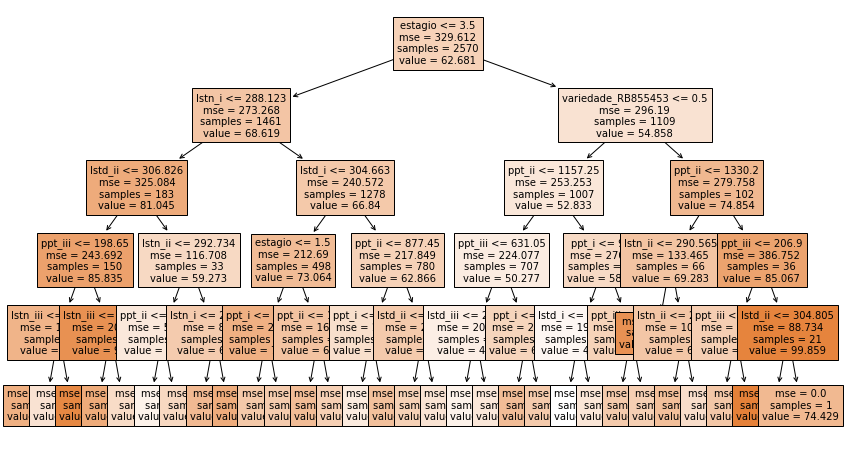

In [ ]:
plt.figure(figsize=(14,8))
tree.plot_tree(tree_model,
               feature_names=X_test.columns,
               filled=True,
               fontsize=10);

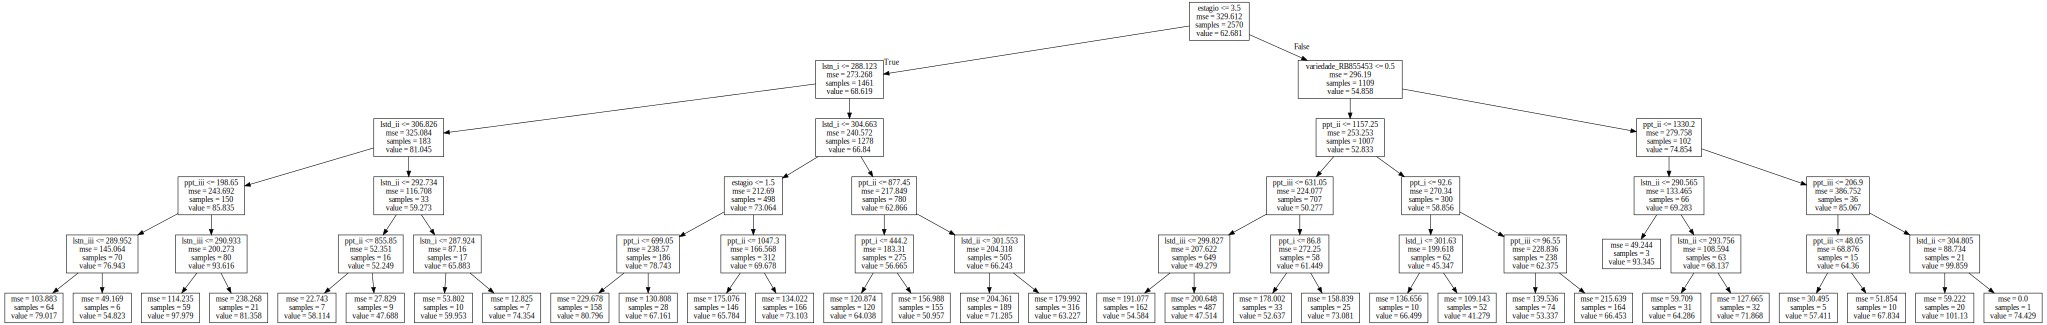

In [ ]:
import graphviz

tree_graph = tree.export_graphviz(tree_model, feature_names=X_test.columns)
graphviz.Source(tree_graph)

##3.7 LIME

In [ ]:
!pip install lime

In [ ]:
#bibliotecas
import lime
import lime.lime_tabular

##3.8 SHAP

In [ ]:
!pip install shap
!pip install catboost

     |████████████████████████████████| 66.1MB 57kB/s 


In [ ]:
import shap  # package used to calculate Shap values
from catboost import Pool

In [ ]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(XGB)

In [ ]:
# Calculate Shap values
shap_values = explainer.shap_values(X_test)

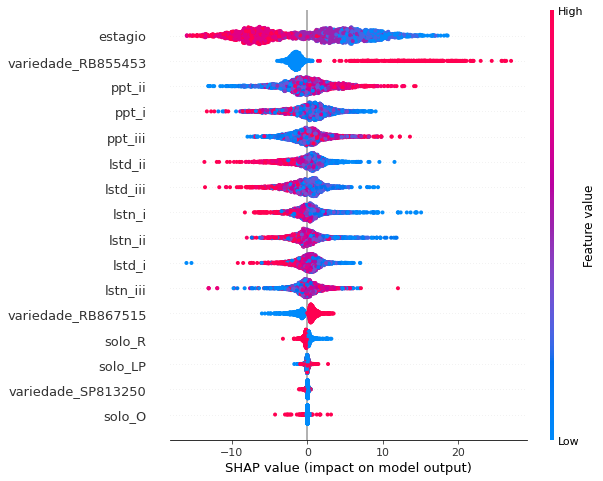

In [ ]:
#summary plot
shap.summary_plot(shap_values, X_test)

In [ ]:
#individual explanation for instance prediction
expected_value = shap_values[0,-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[0,:], X_test.iloc[0,:])